In [46]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from tempfile import TemporaryDirectory

In [47]:
# Set global variables

data_path = './datasets'
trainset_path = data_path + '/train'
testset_path = data_path + '/test'
valset_path = data_path + '/val'

classes = ['Normal', 'Pneumonia']

BATCH_SIZE = 4
NUM_WORKERS = 2
LOSS_FUNCTION = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
MOMENTUM = 0.9
NUM_EPOCHS=20
STEP_SIZE=7
GAMMA=0.1

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of images in ./datasets/train: 5216
Number of images in Normal class: 1341
Number of images in Pneumonia class: 3875


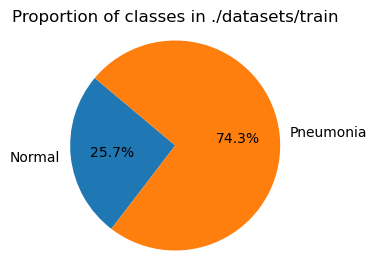

In [48]:
# View training dataset info

def viewDatasetInfo(path):
    normal = os.listdir(path + '/NORMAL')
    pneumonia = os.listdir(path + '/PNEUMONIA')
    quantities = [len(normal), len(pneumonia)]
    plt.figure(figsize=(4, 3))
    plt.pie(quantities, labels=classes, autopct='%1.1f%%', startangle=140)
    plt.title(f"Proportion of classes in {path}")
    plt.axis('equal')
    print(f"Number of images in {path}: {sum(quantities)}")
    print(f"Number of images in {classes[0]} class: {quantities[0]}")
    print(f"Number of images in {classes[1]} class: {quantities[1]}")
    plt.show()

viewDatasetInfo(trainset_path)

In [49]:
# Load datasets

trainset = torchvision.datasets.ImageFolder(root=trainset_path, transform=transform)
testset = torchvision.datasets.ImageFolder(root=testset_path, transform=transform)
valset = torchvision.datasets.ImageFolder(root=valset_path, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
valloder = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# save loaders on a dict to simplify access during training loop
training_loop_loaders = {'train': trainloader, 'val': valloder}

trainset_size = len(trainset)
testset_size = len(testset)
valset_size = len(valset)

datasets_sizes = {'train': trainset_size, 'val': valset_size, 'test': testset_size}

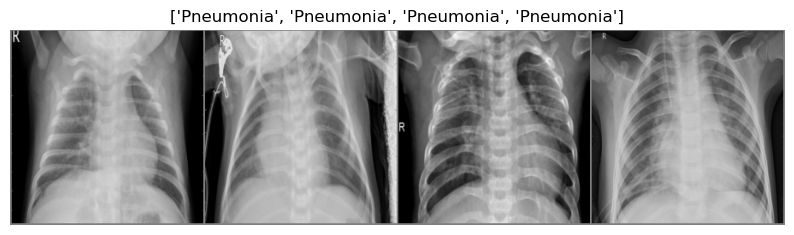

In [50]:
# View images from data

def show_batch(img, title = None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
show_batch(img_grid, title=[classes[x] for x in labels])

In [51]:
# Finetunning a CNN pre-trained model (mobilenet_v2)

model_ft = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Get the numbers of inputs of the last layer
in_features = model_ft.classifier[-1].in_features

# Change the last layer output to the number of classes
model_ft.classifier[-1] = nn.Linear(in_features, len(classes))

model_ft = model_ft.to(device)

In [52]:
# Define Loss Function, Optimizer and Learning Rate Scheduler

criterion = LOSS_FUNCTION
optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)

In [53]:
# Define vars to plot loss and accuracy

epochs_loss = {'train': [], 'val': []}
epochs_accuracy = {'train': [], 'val': []}

In [54]:
# Training function (contains the Training Loop)

def train_model(model, criterion, optimizer, scheduler, num_epochs):
  since = time.time()

  # Temporary directory to save training checkpoints
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      # Train and validation phase
      for phase in ['train', 'val']:
        
        if phase == 'train':
          model.train()
        else:
          model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in training_loop_loaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          # feed forward (track history if only in train)
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / datasets_sizes[phase]
        epoch_acc = running_corrects.double() / datasets_sizes[phase]

        epochs_loss[phase].append(epoch_loss)
        epochs_accuracy[phase].append(epoch_acc)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model if it is the best until now
        if phase == 'val'and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_params_path)

      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
  
  return model
          
  

In [55]:
# Train model

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/19
----------
train Loss: 0.2374 Acc: 0.9049
val Loss: 0.5645 Acc: 0.6250

Epoch 1/19
----------
train Loss: 0.1113 Acc: 0.9590
val Loss: 0.3100 Acc: 0.8125

Epoch 2/19
----------
train Loss: 0.0612 Acc: 0.9774
val Loss: 0.4511 Acc: 0.7500

Epoch 3/19
----------
train Loss: 0.0413 Acc: 0.9862
val Loss: 0.2596 Acc: 0.8125

Epoch 4/19
----------
train Loss: 0.0290 Acc: 0.9896
val Loss: 0.3299 Acc: 0.8750

Epoch 5/19
----------
train Loss: 0.0159 Acc: 0.9950
val Loss: 0.1660 Acc: 0.9375

Epoch 6/19
----------
train Loss: 0.0061 Acc: 0.9990
val Loss: 0.2034 Acc: 0.8750

Epoch 7/19
----------
train Loss: 0.0044 Acc: 0.9998
val Loss: 0.4366 Acc: 0.8125

Epoch 8/19
----------
train Loss: 0.0032 Acc: 0.9996
val Loss: 0.1881 Acc: 0.9375

Epoch 9/19
----------
train Loss: 0.0035 Acc: 0.9992
val Loss: 0.3165 Acc: 0.8750

Epoch 10/19
----------
train Loss: 0.0032 Acc: 0.9994
val Loss: 0.2694 Acc: 0.8750

Epoch 11/19
----------
train Loss: 0.0032 Acc: 0.9994
val Loss: 0.2934 Acc: 0.8750

Ep

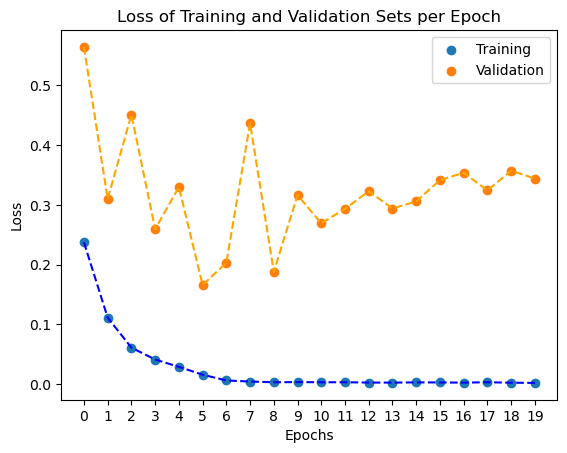

In [63]:
# Visualize model training loss

epochs_list = range(0, NUM_EPOCHS)

# Plot training loss
plt.scatter(epochs_list, epochs_loss['train'], label='Training')
plt.plot(epochs_list, epochs_loss['train'], linestyle='dashed', color='blue')

# Plot validation loss
plt.scatter(epochs_list, epochs_loss['val'], label='Validation')
plt.plot(epochs_list, epochs_loss['val'], linestyle='dashed', color='orange')

# Adds labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of Training and Validation Sets per Epoch')

# define x axis ticks
plt.xticks(range(0, NUM_EPOCHS, 1))

plt.legend()
plt.show()

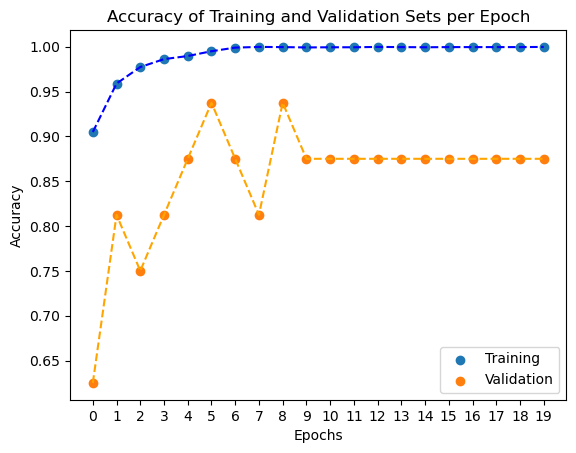

In [65]:
# Visualize model training accuracy

# Convert tensors to numpy arrays
train_accuracy_cpu = [tensor.cpu().numpy() for tensor in epochs_accuracy['train']]
val_accuracy_cpu = [tensor.cpu().numpy() for tensor in epochs_accuracy['val']]

# Plot training accuracy
plt.scatter(epochs_list, train_accuracy_cpu, label='Training')
plt.plot(epochs_list, train_accuracy_cpu, linestyle='dashed', color='blue')

# Plot validation accuracy
plt.scatter(epochs_list, val_accuracy_cpu, label='Validation')
plt.plot(epochs_list, val_accuracy_cpu, linestyle='dashed', color='orange')

# Adds labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of Training and Validation Sets per Epoch')

# define x axis ticks
plt.xticks(range(0, NUM_EPOCHS, 1))

plt.legend()
plt.show()